# Preliminaries and Dataframe Construction

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import random

#Import Encounters from Database Query
df = pd.read_pickle("encounters.pkl")

#Formatting
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs
sns.set_palette(sns.color_palette('Set2')) #set color palette to a nice seaborn style https://seaborn.pydata.org/tutorial/color_palettes.html

c:\Users\Jon\miniconda3\envs\datasci\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


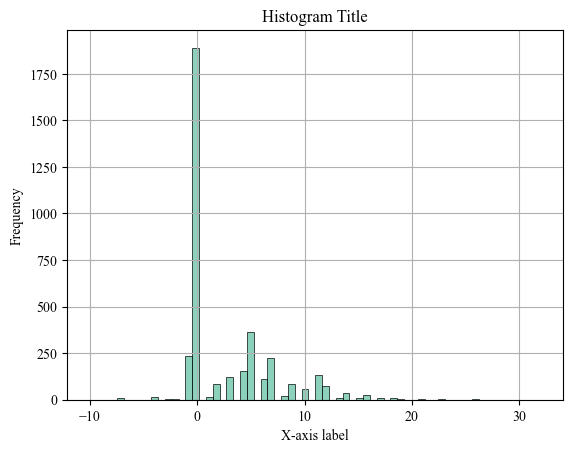

In [2]:
# Create a histogram
sns.histplot(data=df, x="ECI_raw")#, bins=20)

# Add labels and title
plt.xlabel("X-axis label")
plt.ylabel("Frequency")
plt.title("Histogram Title")

# Show the plot
plt.show()

In [3]:
def Maryland_comorbid_cat(row): 
    if row['ECI_raw'] >= severe_cutoff: 
        return +3 
    return +0 

def Maryland_sofa_calc(row) :
    if row['InitialSOFA'] >14:
        return 4
    elif row['InitialSOFA'] >=12:
        return 3
    elif row['InitialSOFA'] >=9:
        return 2
    return 1

In [4]:
##Maryland

df_small_Maryland = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'InitialSOFA', 'ECI_raw', 'Actual_Survival'])
      .assign(Maryland_Age = lambda df_1:
                  pd.cut(df_1['Age'], [0, 50, 70, 85, np.inf], labels=[1, 2, 3, 4])#.astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
beds = 10 #sets numerator of capacity (i.e. number of beds) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_ECI_Maryland = pd.DataFrame()

for c in range(-10,21): #iterate over ECI_raw from 0 to 20
      severe_cutoff = c #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_Maryland
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(ECI_Cutoff = severe_cutoff,
                  Run = i+1,
                  Capacity = (beds/patients),
                  Maryland_S = lambda df_: df_.apply(Maryland_sofa_calc, axis=1),
                  Maryland_C = lambda df_: df_.apply(Maryland_comorbid_cat, axis=1),
                  Allocated = 0, 
                  Survived = 0,
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1,
                  Maryland_Score = lambda df_y: df_y['Maryland_S']+df_y['Maryland_C'],
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY (1)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Maryland_Age') 
                       .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            #.drop(['Age_Group_N', 'Beds'], axis=1)
            #### MUST EITHER (1) Run without grouping and keep ecnounter numbers = large file (i.e. 4GB per file) OR (2) identify fields necessary for analysis and preserve groupby for each
            #.groupby(['Run', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            
            )
            MC_ECI_Maryland = pd.concat([MC_ECI_Maryland, sample.reindex(columns=['ECI_Cutoff', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])])
MC_ECI_Maryland.to_csv('MC_ECI_Maryland.csv', index=False)
